In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from pandas import *
import torch
import torch.nn as nn
from torch.autograd import Variable

In [16]:
def normalizeAB(a,b,x):
    minX=x.min()
    maxX=x.max()
    return (b-a)*((x-minX)/(maxX-minX))+a

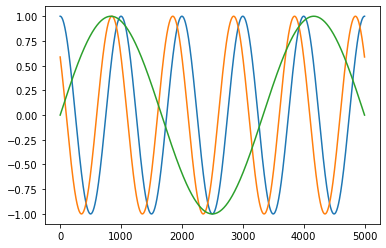

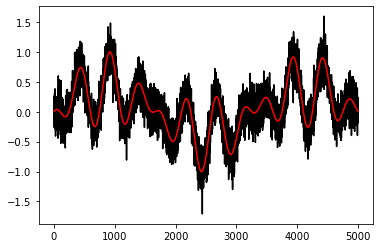

In [24]:
x=linspace(0,numpy.pi*10,5001)
A=numpy.cos(x)
B=numpy.cos(x+numpy.pi*0.3)
C=numpy.cos((x+numpy.pi*5)*0.3)
plot(A)
plot(B)
plot(C)
figure()
rawData=normalizeAB(-1,1,A*B*C)
noise=numpy.random.normal(0,0.2,5001)
data=rawData+noise
plot(data,'k')
plot(rawData,'r')

In [25]:
#RNN

In [26]:
#LSTM